In [1]:
from tqdm import tqdm
from glob import glob

import copy
import numpy as np
import cv2
import pandas as pd
import tensorflow as tf
import os
import seaborn as sb
import matplotlib.pyplot as plt
import collections

from makiflow.augmentation import AffineAugment, ElasticAugment, ImageCutter, Data
from makiflow.augmentation.segmentation import HCScanner
from makiflow.augmentation.segmentation import GDBalancer
from makiflow.augmentation.segmentation.balancing.utils import hcv_to_num
from makiflow.augmentation.segmentation import GD2BBuilder
from makiflow.tf_scripts import set_main_gpu

In [2]:
def mutate_masks(masks, mapping):
    """
    Remaps classes on the given `masks` according to the `mapping`.
    Parameters
    ----------
    masks : list or numpy.array
        List or numpy array of masks.
    mapping : list
        List of tuples: [(source_class_number, new_class_number)],
        where `source_class_number` will be changed to `new_class_number` in the `masks`.
    Returns
    ---------
    new_masks : the same type as `masks`
        New masks with changed class numbers.
    """
    if type(mapping) is not list or (len(mapping) != 0 and type(mapping[0]) is not tuple):
        raise TypeError('mapping should be list of typles')

    new_masks = copy.deepcopy(masks)

    for i in range(len(new_masks)):
        for elem in mapping:
            old_value = elem[0]
            new_value = elem[1]
            new_masks[i][masks[i] == old_value] = new_value

    return  new_masks

In [3]:
set_main_gpu(0)

In [4]:
batch_num = 3

In [5]:
mask_names = glob(f'/mnt/data/med_data/unbalanced_batches/batch_{batch_num}/original_data/masks/*.bmp')

In [6]:
len(mask_names)

99

In [7]:
masks = [cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE) for mask_name in mask_names]

In [8]:
masks = mutate_masks(masks, [(0, 0), (1, 1), (2, 2), (3, 3), (4, 0), (5, 4), (6, 5), (7, 6), (8, 7), (9, 8)])

In [9]:
masks = {mask_name: mask for mask_name, mask in zip(mask_names, masks)}

In [10]:
scanner = HCScanner(masks, 9)
scanner.scan()
scanner.save_info(f'uniq_hvc_{batch_num}.csv', f'masks_hcvg_{batch_num}.csv')
len(scanner.hcv_groups)

Saved!


13

In [11]:
masks_hcvg = pd.read_csv(f'masks_hcvg_{batch_num}.csv', index_col=False)
masks_hcvg.columns = ['path', 'hcvg']
masks_hcvg.head()

,path,hcvg
0,/mnt/data/med_data/unbalanced_batches/batch_3/...,319
1,/mnt/data/med_data/unbalanced_batches/batch_3/...,319
2,/mnt/data/med_data/unbalanced_batches/batch_3/...,447
3,/mnt/data/med_data/unbalanced_batches/batch_3/...,319
4,/mnt/data/med_data/unbalanced_batches/batch_3/...,271


In [12]:
for index, row in masks_hcvg.iterrows():
    print(f"Path to image: {row['path']}, hcvg: {row['hcvg']}")
    break

Path to image: /mnt/data/med_data/unbalanced_batches/batch_3/original_data/masks/0.bmp, hcvg: 319


In [13]:
uniq_hvc = pd.read_csv(f'uniq_hvc_{batch_num}.csv', index_col=False)
# Be carefull, here is unpacking
uniq_hvc.columns = list(['hcvg', *uniq_hvc.columns[1:]])
uniq_hvc.head()

,hcvg,0,1,2,3,4,5,6,7,8
0,319,1,1,1,1,1,1,0,0,1
1,447,1,1,1,1,1,1,0,1,1
2,271,1,1,1,1,0,0,0,0,1
3,303,1,1,1,1,0,1,0,0,1
4,287,1,1,1,1,1,0,0,0,1


In [14]:
uniq_num = uniq_hvc.get_values()
uniq_num = sorted(uniq_num, key=lambda x: x[0]) 
hcv_groups = [vec[1:] for vec in uniq_num]
# hcv_groups = np.delete(hcv_groups, 4, axis=1)
hcv_groups

[array([1, 1, 1, 1, 0, 0, 0, 0, 0]),
 array([1, 1, 1, 1, 1, 0, 0, 0, 0]),
 array([1, 1, 1, 1, 0, 0, 0, 0, 1]),
 array([1, 1, 1, 1, 1, 0, 0, 0, 1]),
 array([1, 1, 1, 1, 0, 1, 0, 0, 1]),
 array([1, 1, 0, 1, 1, 1, 0, 0, 1]),
 array([1, 1, 1, 1, 1, 1, 0, 0, 1]),
 array([1, 1, 1, 1, 1, 0, 1, 0, 1]),
 array([1, 1, 0, 1, 1, 1, 1, 0, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 0, 1]),
 array([1, 1, 1, 1, 1, 0, 0, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 0, 1, 1]),
 array([1, 1, 1, 1, 1, 0, 1, 1, 1])]

Delete 4 class

## GDBalancer Part

In [15]:
initial_weights = collections.OrderedDict(sorted(scanner.hcv_groups.items()))
initial_weights

OrderedDict([(15, 3),
             (31, 1),
             (271, 5),
             (287, 45),
             (303, 1),
             (315, 2),
             (319, 28),
             (351, 3),
             (379, 1),
             (383, 1),
             (415, 5),
             (447, 3),
             (479, 1)])

In [16]:
initial_weights = np.array(list(initial_weights.values()))

In [17]:
initial_weights

array([ 3,  1,  5, 45,  1,  2, 28,  3,  1,  1,  5,  3,  1])

In [18]:
# Initial cardinality distribution
np.round(initial_weights / initial_weights.sum(), 2).reshape(-1, 1)

array([[0.03],
       [0.01],
       [0.05],
       [0.45],
       [0.01],
       [0.02],
       [0.28],
       [0.03],
       [0.01],
       [0.01],
       [0.05],
       [0.03],
       [0.01]])

In [19]:
init_w = np.array([80, 40, 70, 290, 40, 50, 250, 70, 40, 50, 100, 40, 50]) * 2 # 1 batch



# init_w = np.array([98, 98, 95, 60, 90, 98, 96, 70, 94, 94, 98, 96, 98, 98, 98])
init_w = np.array([60, 60, 63, 98, 68, 60, 62, 87, 64, 64, 60, 66, 60]) # The best. i think
# init_w = np.array([100, 100, 103, 138, 108, 100, 102, 127, 104, 104, 100, 106, 100, 100, 100])
# init_w = np.array([138, 138, 135, 100, 130, 138, 137, 110, 134, 134, 138, 132, 138, 138, 138])

In [74]:
init_w = np.array([80, 40, 70, 290, 40, 50, 250, 70, 40, 50, 100, 40, 50]) * 2 
# init_w = np.array([60, 60, 63, 98, 68, 60, 62, 87, 64, 64, 60, 66, 60])
dest_v = np.array([1., 1., 0.95, 1., 0.91, 0.46, 0.90, 0.90, 0.97])

balancer = GDBalancer(
    hcv_groups=np.array(hcv_groups), 
    initial_c=init_w,
    objective='alpha', min_c=20, max_c=800) # 'uniq_hvc.csv'
optimizer = tf.train.AdamOptimizer(0.01)

balancer.add_reg2(0.0004, initial_weights)

In [75]:
sess = tf.Session()
balancer.set_session(sess)

In [76]:
balancer.get_percentage()

array([[100.],
       [100.],
       [ 92.],
       [100.],
       [ 84.],
       [ 40.],
       [ 18.],
       [ 16.],
       [ 90.]], dtype=float32)

In [95]:
iterations = 1000
balancer.optimize(dest_v, optimizer, iterations=iterations, print_period=iterations - 1)

1.075567
[[100.]
 [100.]
 [ 96.]
 [100.]
 [ 92.]
 [ 36.]
 [ 20.]
 [ 21.]
 [ 95.]]
1.0692384
[[100.]
 [100.]
 [ 95.]
 [100.]
 [ 93.]
 [ 36.]
 [ 21.]
 [ 22.]
 [ 96.]]


In [96]:
# Initial cardinality distribution
np.concatenate([np.round(balancer.show_deviation() * -1, 0) ,
                np.round(initial_weights / initial_weights.sum(), 2).reshape(-1, 1)*100], axis=1).astype(np.int32)

array([[ 0,  3],
       [ 0,  1],
       [-3,  5],
       [-9, 45],
       [ 0,  1],
       [-1,  2],
       [-6, 28],
       [ 1,  3],
       [ 2,  1],
       [ 2,  1],
       [ 1,  5],
       [ 2,  3],
       [ 9,  1]], dtype=int32)

In [97]:
balancer.get_weights()

array([[ 62.2913  ],
       [ 20.      ],
       [ 43.85458 ],
       [664.1707  ],
       [ 20.      ],
       [ 20.      ],
       [404.0448  ],
       [ 76.29025 ],
       [ 63.293293],
       [ 62.13554 ],
       [115.70326 ],
       [ 97.7923  ],
       [185.49869 ]], dtype=float32)

In [416]:
balancer.get_percentage()

array([[100.],
       [100.],
       [ 94.],
       [100.],
       [ 92.],
       [ 44.],
       [ 18.],
       [ 20.],
       [ 98.]], dtype=float32)

In [231]:
balancer.get_weights().sum()

1310.0491

## Prepare values to GD2BBuilder

In [467]:
balancer_weights = balancer.get_weights()
balancer_weights = balancer_weights.flatten().round().astype(np.int32)
balancer_weights

array([ 20,  20,  20, 600,  20,  20, 339, 113,  81, 101, 157,  80,  95],
      dtype=int32)

In [468]:
config = {}
for i in range(len(balancer_weights)):
    config[hcv_to_num(balancer.hcv_groups[i])] = balancer_weights[i]

In [104]:
config

Available objects for config:
     AliasManager
     DisplayFormatter
     HistoryManager
     IPCompleter
     IPKernelApp
     InlineBackend
     LoggingMagics
     MagicsManager
     PrefilterManager
     ScriptMagics
     StoreMagics
     ZMQInteractiveShell


In [105]:
balancer.save_cardinalities(f'balancer_cardinalities_{batch_num}.csv')

## GD2BBuilder part

In [115]:
lbl_names = glob(f'/mnt/data/med_data/unbalanced_batches/batch_{batch_num}/original_data/masks/*.bmp')

In [116]:
mask2image = {}
for mask_name in lbl_names:
    mask2image[mask_name] = mask_name.replace('masks', 'images')

In [117]:
pd.DataFrame.from_dict(mask2image, orient='index', columns=['image']).to_csv(f'mi_{batch_num}.csv')

In [141]:
batch_num = 3

In [142]:
builder = GD2BBuilder(
    path_to_balance_config=f'BalancingConfigs/balancer_cardinalities_{batch_num}.csv',
    path_to_hc_list=f'BalancingConfigs/masks_hcvg_{batch_num}.csv',
    path_to_mi=f'BalancingConfigs/mi_{batch_num}.csv',
    resize=(1024, 1024)
)

/home/rustam/anaconda3/lib/python3.6/site-packages/makiflow/augmentation/segmentation/balancing/gdbb_builder.py:24: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  self._balance_c = pd.DataFrame.from_csv(path_to_balance_config)
/home/rustam/anaconda3/lib/python3.6/site-packages/makiflow/augmentation/segmentation/balancing/gdbb_builder.py:25: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  self._load_masks_images(path_to_mi, resize)
/home/rustam/anaconda3/lib/python3.6/site-packages/makiflow/augmentation/segmentation/balancing/gdbb_builder.py:34: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are

Loading masks and images.
Finished.
Group masks and images by their ids.
319 cardinality is 28
447 cardinality is 3
271 cardinality is 5
303 cardinality is 1
287 cardinality is 45
351 cardinality is 3
415 cardinality is 5
315 cardinality is 2
15 cardinality is 3
379 cardinality is 1
479 cardinality is 1
31 cardinality is 1
383 cardinality is 1
Finished.


In [143]:
builder.set_elastic_aug_params((1024, 1024, 3), 700, 11, 7)

In [144]:
builder.create_batch(f'/mnt/data/med_data/balanced_batches/paper_batch_{batch_num}/train_set/orig_set/')

Balancing group 319...
Augmentor updated 7 times.
Finished.
319 ready
Balancing group 447...
Augmentor updated 16 times.
Finished.
447 ready
Balancing group 271...
Augmentor updated 4 times.
Finished.
271 ready
Balancing group 303...
Augmentor updated 10 times.
Finished.
303 ready
Balancing group 287...
Augmentor updated 7 times.
Finished.
287 ready
Balancing group 351...
Augmentor updated 12 times.
Finished.
351 ready
Balancing group 415...
Augmentor updated 11 times.
Finished.
415 ready
Balancing group 315...
Augmentor updated 5 times.
Finished.
315 ready
Balancing group 15...
Augmentor updated 10 times.
Finished.
15 ready
Balancing group 379...
Augmentor updated 32 times.
Finished.
379 ready
Balancing group 479...
Augmentor updated 83 times.
Finished.
479 ready
Balancing group 31...
Augmentor updated 10 times.
Finished.
31 ready
Balancing group 383...
Augmentor updated 31 times.
Finished.
383 ready


In [121]:
test = glob(f'/mnt/data/med_data/balanced_batches/batch_{batch_num}/train_set/aug_set/set_1024_wo_elastic_paper_test#3_3/masks/*.bmp')
lbls = []
for mask_name in test:
    lbls += [cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)]
len(lbls)

908

In [493]:
sb.heatmap(lbls[231])

IndexError: list index out of range

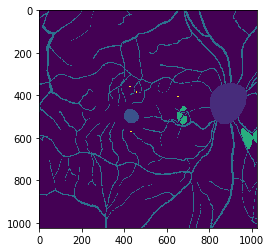

In [433]:
plt.imshow(lbls[44])

In [122]:
import math
def get_CR_vector(lbls, count_classes):
  uniq = dict([(str(i),0) for i in range(count_classes)])
  
  for i in range(len(lbls)):
    a,b = np.unique(lbls[i], return_counts=True)
    for num in a:
        uniq[str(num)] += 1
  print(uniq)
  return [round(uniq[k] / len(lbls),2) for k in uniq]

In [123]:
get_CR_vector(lbls, 10)

{'0': 908, '1': 906, '2': 866, '3': 908, '4': 106, '5': 845, '6': 328, '7': 184, '8': 190, '9': 867}


[1.0, 1.0, 0.95, 1.0, 0.12, 0.93, 0.36, 0.2, 0.21, 0.95]

In [453]:
lbls = {mask_name: mask for mask_name, mask in zip(test, lbls)}
scanner = HCScanner(lbls, 10)
scanner.scan()

In [454]:
scanner.hcv_groups

{415: 200,
 319: 345,
 351: 157,
 479: 176,
 271: 34,
 31: 20,
 15: 20,
 383: 83,
 303: 88,
 287: 505,
 315: 84,
 447: 73,
 431: 74,
 477: 8}

In [712]:
len(lbls)

1183

In [2]:
def get_train_data(path='/mnt/data/med_data/unbalanced_batches/batch_3'):
    Ytrain = []
    masks = glob.glob(path + '/masks/*.bmp')
    masks.sort()
    for mask_name in tqdm(masks):
        mask = cv2.imread(mask_name)
        Ytrain.append(mask[:,:,0])
        if np.max(mask) >= 10:
            print(np.max(mask), f' in image {mask_name} ')
    return Ytrain

In [3]:
x = get_train_data()

100%|██████████| 5049/5049 [00:31<00:00, 161.33it/s]


In [ ]:
import seaborn as sns

In [ ]:
sns.heatmap(Ytrain[0])

In [ ]:
cv2.imwrite('2.bmp', test)

In [ ]:
x=cv2.imread('/mnt/data/med_data/balanced_batches/bb_danil1/masks/527_0.bmp')

In [ ]:
sns.heatmap(x)

In [ ]:
test = cv2.resize(x, (1024,1024), interpolation=cv2.INTER_NEAREST)